In [1]:
from app.app import App
import random as rd
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt

from utils.population import Population
from utils.pipe import Pipe

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002B491C39A50>>
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\threading.py", line 1501, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


In [ ]:
window_width, window_height = 800, 600

n_birds = 32 # Number of birds in our population
n_reproducers = int(np.ceil(0.10 * n_birds)) # Number of birds that are allowed to reproduce
print(f"n_reproducers {n_reproducers}")
x_birds = 200
# reproducers = []
mutation_rate = 0.02

dt = 1 # ms
time_since_last_pipe = 0
dist_between_pipes = 400
floor_height = 50
floor_frontier = (x_birds, window_height - floor_height)
ceiling_frontier = (x_birds, 0)

max_distances = []
n_pipes_created = []

n_reproducers 4


In [ ]:
# This Function takes the indices of the reproducers after the generation test and returns a list of new genomes for the next generation.
def get_next_generation_genomes(population):
    # Getting the best birds' genomes
    print("Getting the best birds' genomes")
    selected_genomes = [population.brains[reproducer_index].genome for reproducer_index in population.reproducers]
    print(f"Selected {len(selected_genomes)} Genomes.")

    # Creating n_birds new genomes by crossing over the selected genomes
    print("Creating n_birds new genomes by crossing over the selected genomes")
    new_genomes = []
    for i in range(n_birds):
        i1 = np.random.randint(0, len(selected_genomes))
        i2 = np.random.randint(0, len(selected_genomes))
        while i1 == i2: # making sure i1 and i2 are different
            i2 = np.random.randint(0, len(selected_genomes))
        
        genome_parent1 = selected_genomes[i1]
        genome_parent2 = selected_genomes[i2]

        # crossover_point = np.random.randint(0, len(genome_parent1))
        crossover_rate = rd.random()
        crossover_points = {k: int(crossover_rate * genome_parent1[k].size) for k in genome_parent1.keys()}

        # To create the genome of the child we take each layers of both parents and we take the weights
        # of the first parent's genome until the crossover point and we finish with the second parent's
        # genome.
        genome_child = {
            k: np.concatenate((
                genome_parent1[k].flatten()[:crossover_points[k]],
                genome_parent2[k].flatten()[crossover_points[k]:]
            )).reshape(genome_parent1[k].shape)
            for k in genome_parent1.keys()
        }
        new_genomes.append(genome_child)

    # Mutations on the newborns
    print(f"Mutations on the newbords (mutation rate: {mutation_rate})")
    # The mutation is a natural process when you create an new child. Here we do random mutations
    # with the probability of mutation_rate, which means each weight or bias of the neural
    # network has a probability of mutation_rate to be randomly modified. To minimise the
    # complexity, we create a mutation_mask which decides which values will be modified. Then we
    # create an array where all the values have been modified, and finally we update the values
    # of the layer which have been chosen by the mutation_mask to give them the value of the
    # newly created array mutated_values.
    mutated_genomes = []
    for new_genome in new_genomes:
        mutated_genome = {}
        for k in new_genome:
            layer = new_genome[k].copy()
            # print(f"layer.shape {layer.shape}")
            mutation_mask = np.random.rand(len(layer)) < mutation_rate
            mutated_values = np.random.uniform(low=np.min(layer), high=np.max(layer), size=layer.shape)
            # print(f"mutated_values.shape {mutated_values.shape}")
            layer[mutation_mask] = mutated_values[mutation_mask]
            mutated_genome[k] = layer
        mutated_genomes.append(mutated_genome)

    return mutated_genomes

In [ ]:
# This Function finds the next pipe coming and returns its distance to the birds and its height
def find_next_pipe(pipes: list[Pipe], x_birds: int):
    coming_pipes = [pipe for pipe in pipes if pipe.x + pipe.width > x_birds]  # Getting the coming pipes depending on their x attribute
    next_pipe = coming_pipes[0]  # The first one is the firstly added one, so the really next one
    next_pipe_dist = next_pipe.x - x_birds  # Getting its distance on the x axis
    next_pipe_height = next_pipe.height  # Getting its height
    return next_pipe_dist, next_pipe_height

In [ ]:
def simulate(n_generations):
    # Initialising variables
    window_width, window_height = 800, 600

    n_birds = 32 # Number of birds in our population
    n_reproducers = int(np.ceil(0.10 * n_birds)) # Number of birds that are allowed to reproduce
    print(f"n_reproducers {n_reproducers}")
    x_birds = 200
    # reproducers = []
    mutation_rate = 0.02
    
    dt = 1 # ms
    time_since_last_pipe = 0
    dist_between_pipes = 400
    floor_height = 50
    floor_frontier = (x_birds, window_height - floor_height)
    ceiling_frontier = (x_birds, 0)
    
    max_distances = []
    n_pipes_created = []
    
    genomes = None # Initial genome of the birds will be randomly generated

    # Launching Simulation
    for i in range(n_generations):
        print("#"*150)
        print(f"GENERATION {i}")
        print("#"*150)
        # Creating the Population
        print("Creating the Population")
        population = Population(n_birds=n_birds, n_reproducers=n_reproducers, genomes=genomes)
        # Generating the Pipes²
        print("Generating the Pipes")
        pipe1 = Pipe(window_dim=(window_width, window_height), height=300)
        pipe_speed = pipe1.speed
        pipes = [pipe1]
    
        # Used just for not choosing several times the same reproducers
        reproducers_selected = False
    
        # Used to record the performance of the best bird of the current generation
        max_dist = 0
    
        # Launching the Generation Simulation
        print("Launching the Generation Simulation")
        running = True
        while running:
            # Moving the pipes
            for pipe in pipes:
                pipe.move()
            # Generating new pipes (no acceleration of the pipes)
            dist_since_last_pipe = (pipe_speed / dt) * time_since_last_pipe
            if dist_since_last_pipe >= dist_between_pipes:
                new_pipe_height = rd.randint(0, window_height - 200 - floor_height)
                new_pipe = Pipe(window_dim=(window_width, window_height), height=new_pipe_height)
                pipes.append(new_pipe)
                time_since_last_pipe = 0
            
            # Making the birds fly
            population.fly()
            # Updating the max_dist with the distance done after this time step
            max_dist += pipe_speed * dt
    
            # Collecting information about the next coming pipe
            next_pipe_dist, next_pipe_height = find_next_pipe(pipes, x_birds)
            # print("Making the Birds Flap")
            outputs = []
            for i, brain in enumerate(population.brains):
                input = population.birds[i,:]
                output = brain.get_response(input, next_pipe_dist, next_pipe_height)
                outputs.append(output.detach().numpy()[0])  # output is a tensor with 1 elt so we detach it, convert to numpy and then get the only elt to get a float
    
            flap_indices = [i for i, value in enumerate(outputs) if value > 0]
            # Some birds might be dead so we don't take them
            real_flap_indices = [ind for ind in flap_indices if population.birds[ind, 3]]
            # print(f"{len(flap_indices)} Birds are selected to flap but {len(real_flap_indices)} are alive.")
            population.flap(index=real_flap_indices)
    
            # Collision
            global_frontier = [floor_frontier] + [ceiling_frontier] + list(itertools.chain(*[curr_pipe.frontier for curr_pipe in pipes])) # concatenating all the frontiers
            # print(f"frontier {frontier}")
            reproducers = population.kill(global_frontier, floor_frontier, ceiling_frontier)
    
            # Condition for stopping the simulation
            running = False if population.all_birds_dead() else True
    
            # making time run
            time_since_last_pipe += dt
    
        # Printing the best distance
        print(f"The best Bird of Generation {i} achieved a distance of {max_dist}")
        max_distances.append(max_dist)
        n_pipes_created.append(len(pipes))
        
        # Creating the next generation
        print("Creating the next generation")
        # genomes = mutated_genomes
        genomes = get_next_generation_genomes(population=population)

    return max_distances, n_pipes_created

In [ ]:
n_generations = 5
start_time = time.time()
max_distances, n_pipes_created = simulate(n_generations)
end_time = time.time()

n_reproducers 4
######################################################################################################################################################
GENERATION 0
######################################################################################################################################################
Creating the Population
Population -> __init__ : initialising the brains of the birds
Generating the Pipes
Launching the Generation Simulation
The best Bird of Generation 31 achieved a distance of 581
Creating the next generation
Getting the best birds' genomes
Selected 4 Genomes.
Creating n_birds new genomes by crossing over the selected genomes
Mutations on the newbords (mutation rate: 0.02)
######################################################################################################################################################
GENERATION 1
############################################################################################################

Best Distances: [581, 525, 581, 581, 581]
Time Taken: 6.100006818771362


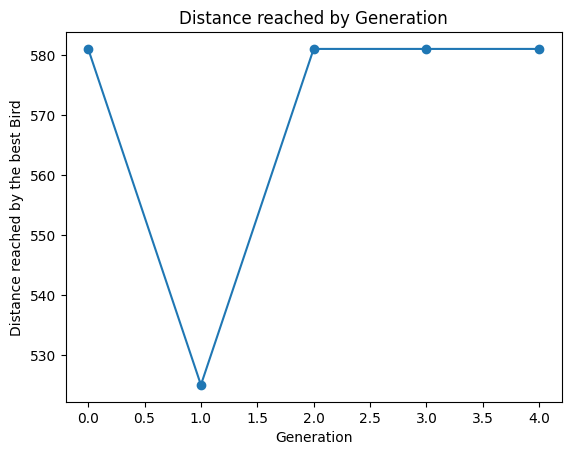

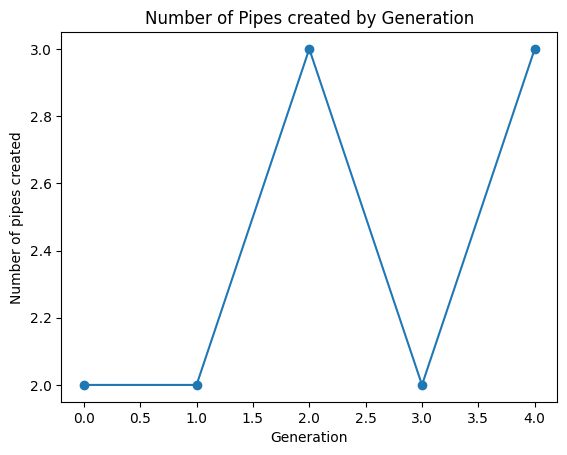

In [ ]:
print(f"Best Distances: {max_distances}")
print(f"Time Taken: {end_time - start_time}")

plt.plot(max_distances, 'o-')
plt.title('Distance reached by Generation')
plt.xlabel('Generation')
plt.ylabel('Distance reached by the best Bird')
plt.show()

plt.plot(n_pipes_created, 'o-')
plt.title('Number of Pipes created by Generation')
plt.xlabel('Generation')
plt.ylabel('Number of pipes created')
plt.show()

In [ ]:
def simulate_for(duration):
    # Initialising variables
    window_width, window_height = 800, 600

    n_birds = 64 # Number of birds in our population
    percentage_reproducers = 0.1
    n_reproducers = int(np.ceil(percentage_reproducers * n_birds)) # Number of birds that are allowed to reproduce
    print(f"n_reproducers {n_reproducers}")
    x_birds = 200
    # reproducers = []
    mutation_rate = 0.02
    
    dt = 1 # ms
    time_since_last_pipe = 0
    dist_between_pipes = 400
    floor_height = 50
    floor_frontier = (x_birds, window_height - floor_height)
    ceiling_frontier = (x_birds, 0)
    
    max_distances = []
    n_pipes_created = []
    
    genomes = None # Initial genome of the birds will be randomly generated

    n_gen = 0  # Number of current generation
    start_time = time.time()
    # Launching Simulation
    while time.time() < start_time + duration:
        print(f"{time.time()} vs. {start_time + duration}")
        print(f"remaining: {round(start_time + duration - time.time())}")
    # for i in range(n_generations):
        print("#"*150)
        print(f"GENERATION {n_gen}")
        print("#"*150)
        # Creating the Population
        print("Creating the Population")
        population = Population(n_birds=n_birds, n_reproducers=n_reproducers, genomes=genomes)
        # Generating the Pipes²
        print("Generating the Pipes")
        pipe1 = Pipe(window_dim=(window_width, window_height), height=300)
        pipe_speed = pipe1.speed
        pipes = [pipe1]
    
        # Used just for not choosing several times the same reproducers
        reproducers_selected = False
    
        # Used to record the performance of the best bird of the current generation
        max_dist = 0
    
        # Launching the Generation Simulation
        print("Launching the Generation Simulation")
        running = True
        while running:
            # Moving the pipes
            for pipe in pipes:
                pipe.move()
            # Generating new pipes (no acceleration of the pipes)
            dist_since_last_pipe = (pipe_speed / dt) * time_since_last_pipe
            if dist_since_last_pipe >= dist_between_pipes:
                new_pipe_height = rd.randint(0, window_height - 200 - floor_height)
                new_pipe = Pipe(window_dim=(window_width, window_height), height=new_pipe_height)
                pipes.append(new_pipe)
                time_since_last_pipe = 0
            
            # Making the birds fly
            population.fly()
            # Updating the max_dist with the distance done after this time step
            max_dist += pipe_speed * dt
    
            # Collecting information about the next coming pipe
            next_pipe_dist, next_pipe_height = find_next_pipe(pipes, x_birds)
            # print("Making the Birds Flap")
            outputs = []
            for i, brain in enumerate(population.brains):
                input = population.birds[i,:]
                output = brain.get_response(input, next_pipe_dist, next_pipe_height)
                outputs.append(output.detach().numpy()[0])  # output is a tensor with 1 elt so we detach it, convert to numpy and then get the only elt to get a float
    
            flap_indices = [i for i, value in enumerate(outputs) if value > 0]
            # Some birds might be dead so we don't take them
            real_flap_indices = [ind for ind in flap_indices if population.birds[ind, 3]]
            # print(f"{len(flap_indices)} Birds are selected to flap but {len(real_flap_indices)} are alive.")
            population.flap(index=real_flap_indices)
    
            # Collision
            global_frontier = [floor_frontier] + [ceiling_frontier] + list(itertools.chain(*[curr_pipe.frontier for curr_pipe in pipes])) # concatenating all the frontiers
            # print(f"frontier {frontier}")
            reproducers = population.kill(global_frontier, floor_frontier, ceiling_frontier)
    
            # Condition for stopping the simulation
            running = False if population.all_birds_dead() else True
    
            # making time run
            time_since_last_pipe += dt

        n_gen += 1
    
        # Printing the best distance
        print(f"The best Bird of Generation {i} achieved a distance of {max_dist}")
        max_distances.append(max_dist)
        n_pipes_created.append(len(pipes))

        print(f"RESULTS: Created {len(pipes)} pipes, reached a distance of {max_dist}")
        
        # Creating the next generation
        print("Creating the next generation")
        # genomes = mutated_genomes
        genomes = get_next_generation_genomes(population=population)

            

    return max_distances, n_pipes_created

In [ ]:
sec = 1
minutes = 60 * sec
hours = 60 * minutes
day = 24 * hours

In [ ]:
start_time = time.time()
max_distances, n_pipes_created = simulate_for(30 * minutes)
end_time = time.time()

n_reproducers 7
1721938039.091944 vs. 1721939839.091944
remaining: 1800
######################################################################################################################################################
GENERATION 0
######################################################################################################################################################
Creating the Population
Population -> __init__ : initialising the brains of the birds
Generating the Pipes
Launching the Generation Simulation
The best Bird of Generation 63 achieved a distance of 581
RESULTS: Created 2 pipes, reached a distance of 581
Creating the next generation
Getting the best birds' genomes
Selected 7 Genomes.
Creating n_birds new genomes by crossing over the selected genomes
Mutations on the newbords (mutation rate: 0.02)
1721938041.3703938 vs. 1721939839.091944
remaining: 1798
###########################################################################################################

KeyboardInterrupt: 

Best Distances: [581, 658, 630, 658, 644, 630, 686, 630, 630, 630, 700, 693, 938, 686, 938, 700, 672, 672, 812, 1267, 749, 812, 1260, 791, 1288, 721, 1302, 728, 917, 707, 868, 777, 903, 700, 889, 791, 854, 714, 2044, 798, 924, 700, 931, 805, 700, 861, 812, 805, 819, 763, 868, 798, 805, 826, 798, 784, 819, 805, 805, 938, 700, 805, 1225, 1239, 791, 798, 924, 791, 721, 917, 707, 812, 812, 812, 819, 805, 1225, 1211, 917, 833, 1092, 1274, 777, 910, 693, 910, 714, 910, 833, 693, 812, 812, 861, 770, 1680, 777, 1190, 1267, 763, 910, 805, 721, 826, 1218, 798, 868, 756, 826, 826, 784, 889, 749, 805, 805, 917, 707, 11592, 623, 16730, 3633, 5698, 700, 17164, 700, 6160, 31710]
Time Taken: 2417.0591127872467


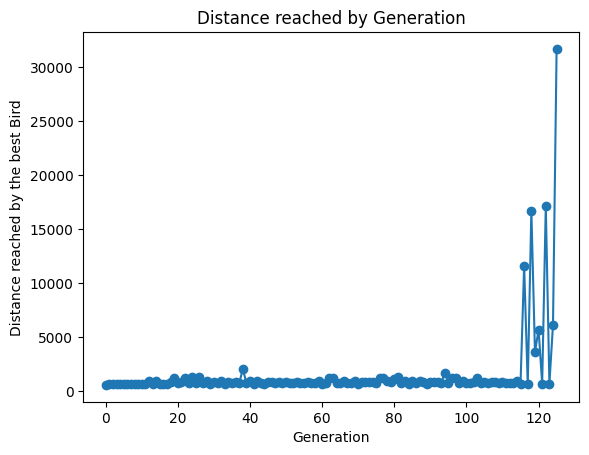

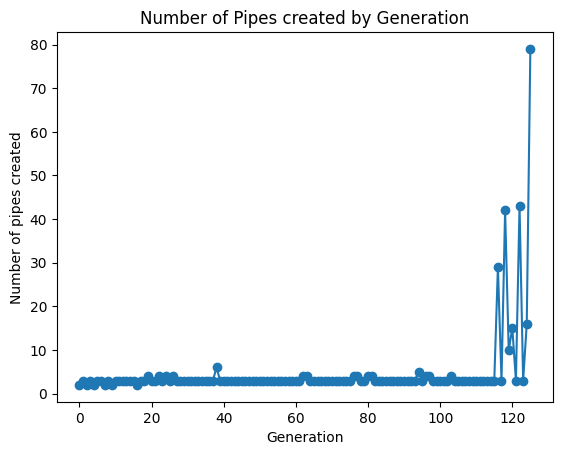

In [ ]:
print(f"Best Distances: {max_distances}")
print(f"Time Taken: {end_time - start_time}")

plt.plot(max_distances, 'o-')
plt.title('Distance reached by Generation')
plt.xlabel('Generation')
plt.ylabel('Distance reached by the best Bird')
plt.show()

plt.plot(n_pipes_created, 'o-')
plt.title('Number of Pipes created by Generation')
plt.xlabel('Generation')
plt.ylabel('Number of pipes created')
plt.show()